# Facial Expressoin Recognition with Convolutional Neural Network

## Imports

In [437]:
import os
import tarfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [438]:
project_name = '004FacialExpressoRecogCNNApproach'

## Info of the Dataset

In [439]:
data_dir = '../input/facial-expression-recog-image-ver-of-fercdataset/Dataset'
classes = os.listdir(data_dir + '/train')

No. of training images of each class in training set:-

In [440]:
for i in classes:
    var_files = os.listdir(data_dir + '/train/' + i)
    print(i, ':', len(var_files))

neutral : 5572
sadness : 5483
anger : 4462
disgust : 493
fear : 4593
surprise : 3586
happiness : 8110


No. of images of each class in test set:-

In [441]:
for i in classes:
    var_files = os.listdir(data_dir + '/test/' + i)
    print(i,': ',len(var_files))

neutral :  626
sadness :  594
anger :  491
disgust :  55
fear :  528
surprise :  416
happiness :  879


creating the `dataset` variable

In [442]:
dataset = ImageFolder(
    data_dir + '/train', 
    transform = ToTensor()
                     )

In [443]:
dataset

Dataset ImageFolder
    Number of datapoints: 32298
    Root location: ../input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train
    StandardTransform
Transform: ToTensor()

In [444]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 48, 48]) 0


tensor([[[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.6353],
         ...,
         [0.1412, 0.1490, 0.1451,  ..., 0.4980, 0.5294, 0.5255],
         [0.1490, 0.1529, 0.1647,  ..., 0.4314, 0.4549, 0.4745],
         [0.1529, 0.1569, 0.1647,  ..., 0.4667, 0.5255, 0.5529]],

        [[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.6353],
         ...,
         [0.1412, 0.1490, 0.1451,  ..., 0.4980, 0.5294, 0.5255],
         [0.1490, 0.1529, 0.1647,  ..., 0.4314, 0.4549, 0.4745],
         [0.1529, 0.1569, 0.1647,  ..., 0.4667, 0.5255, 0.5529]],

        [[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.

In [445]:
print(dataset.classes)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [446]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  fear (2)


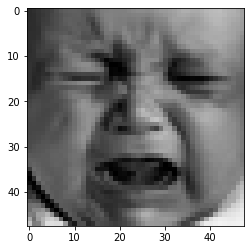

In [447]:
show_example(*dataset[5300])

## **Training and Validation Datasets**

In [448]:
random_seed = 42
torch.manual_seed(random_seed)

In [449]:
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(29069, 3229)

In [450]:
batch_size = 64

## Data Loaders

In [451]:
train_dl = DataLoader(
                        train_ds, 
                        batch_size, 
                        shuffle=True, 
                        num_workers=4,
                        pin_memory=True   
                     )

val_dl = DataLoader(
                        val_ds, 
                        batch_size*2, 
                        num_workers=4, 
                        pin_memory=True
                    )

In [452]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

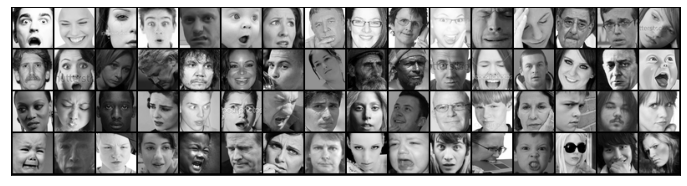

In [453]:
show_batch(train_dl)

## Defining the Model(CNN)

In [454]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [455]:
# simple_model = nn.Sequential(
#     nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
#     nn.MaxPool2d(2, 2)
# )

In [456]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [457]:
class FacialExpressRecogCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 24 x 24

            nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 192 x 12 x 12

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 384 x 6 x 6

            nn.Flatten(), 
            nn.Linear(384*6*6, 2304),
            nn.ReLU(),
            nn.Linear(2304, 1152),
            nn.ReLU(),
            nn.Linear(1152, 576),
            nn.ReLU(),
            nn.Linear(576, 7)
                                    )
        
    def forward(self, xb):
        return self.network(xb)

In [458]:
model = FacialExpressRecogCnnModel()
model

FacialExpressRecogCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=13824, out_features=2304, bias=True)
    (17): ReLU()
    (18): Linear(in_features=2304, 

In [459]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 48, 48])
out.shape: torch.Size([64, 7])
out[0]: tensor([-0.0139, -0.0263,  0.0084, -0.0246,  0.0247, -0.0395,  0.0286],
       grad_fn=<SelectBackward>)


## Using a GPU

In [460]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [461]:
device = get_default_device()
device

device(type='cuda')

In [462]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

FacialExpressRecogCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=13824, out_features=2304, bias=True)
    (17): ReLU()
    (18): Linear(in_features=2304, 

## Functions to train the Model

In [463]:
@torch.no_grad()    # This is to say that PyTorch to stop tracking of grad
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [464]:
model = to_device(FacialExpressRecogCnnModel(), device)

In [465]:
evaluate(model, val_dl)

{'val_loss': 1.9499311447143555, 'val_acc': 0.015324519015848637}

In [466]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [467]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8159, val_loss: 1.7632, val_acc: 0.2868
Epoch [1], train_loss: 1.6246, val_loss: 1.5989, val_acc: 0.3968
Epoch [2], train_loss: 1.4690, val_loss: 1.4336, val_acc: 0.4348
Epoch [3], train_loss: 1.3550, val_loss: 1.3307, val_acc: 0.4915
Epoch [4], train_loss: 1.2316, val_loss: 1.2528, val_acc: 0.5194
Epoch [5], train_loss: 1.1294, val_loss: 1.2250, val_acc: 0.5285
Epoch [6], train_loss: 1.0152, val_loss: 1.2058, val_acc: 0.5511
Epoch [7], train_loss: 0.8930, val_loss: 1.2453, val_acc: 0.5408
Epoch [8], train_loss: 0.7641, val_loss: 1.3377, val_acc: 0.5499
Epoch [9], train_loss: 0.6186, val_loss: 1.4425, val_acc: 0.5651


In [468]:
#num_epochs = 20
#opt_func = torch.optim.Adam
#lr = 0.001

In [469]:
#history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [470]:
#num_epochs = 30
#opt_func = torch.optim.Adam
#lr = 0.001

In [471]:
#history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [472]:
evaluate(model, test_loader)

{'val_loss': 1.3759284019470215, 'val_acc': 0.5701508522033691}

## Plotting Functions

In [473]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

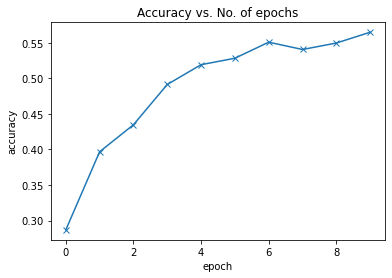

In [474]:
plot_accuracies(history)

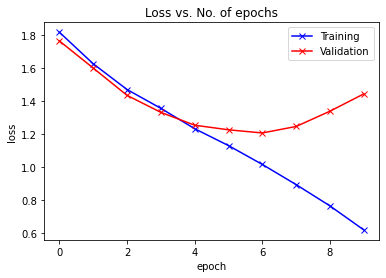

In [475]:
plot_losses(history)

## Function to Predict

In [476]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

## Test Dataset
Lets store the test images in the `test_dataset` variable

In [477]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

### Predictions

Label: anger , Predicted: anger


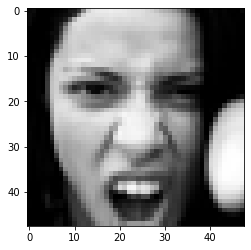

In [478]:
img, label = test_dataset[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: fear , Predicted: fear


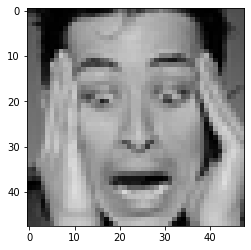

In [479]:
img, label = test_dataset[1034]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: neutral , Predicted: neutral


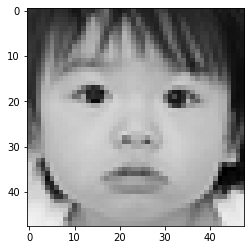

In [480]:
img, label = test_dataset[2315]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [482]:
stop here

SyntaxError: invalid syntax (<ipython-input-482-a96ba3aab008>, line 1)

## Commit to Jovian

In [ ]:
!pip install jovian

In [ ]:
import jovian
jovian.commit(project=project_name)

In [486]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.3759284019470215, 'val_acc': 0.5701508522033691}

In [487]:
jovian.log_metrics(
                    test_loss=result['val_loss'], 
                    test_acc=result['val_acc'],
                    train_loss=history[-1]['train_loss'], 
                    val_loss=history[-1]['val_loss'], 
                    val_acc=history[-1]['val_acc']
                   )

[jovian] Metrics logged.


In [488]:
num_epochs = [10]
opt_func = torch.optim.Adam
lr = [0.001]

In [489]:
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [490]:

jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/manishshah120/004FacialExpressoRecogCNNApproach


<IPython.core.display.Javascript object>